# Классификация гистологических изображений молочной железы на наличие рака

Этот набор данных состоит из 5547 гистологических изображений молочной железы размером 50 x 50. Цель состоит в том, чтобы классифицировать раковые изображения.

In [59]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adagrad

from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout, SpatialDropout2D
from keras.layers import Dense
from keras import backend as K
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [60]:
X = np.load('X.npy')

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('Y.npy')

perm_array = np.arange(len(X))
np.random.shuffle(perm_array)
X = X[perm_array]
Y = Y[perm_array]

print('X-images.shape =', X.shape, ', Y-images.shape =', Y.shape)

X-images.shape = (5547, 50, 50, 3) , Y-images.shape = (5547,)


In [61]:
print(len(X[Y==0]), 'установленных диагнозов.', len(X[Y==1]), 'не установленных диагнозов')

2759 установленных диагнозов. 2788 не установленных диагнозов


## Примеры изображений

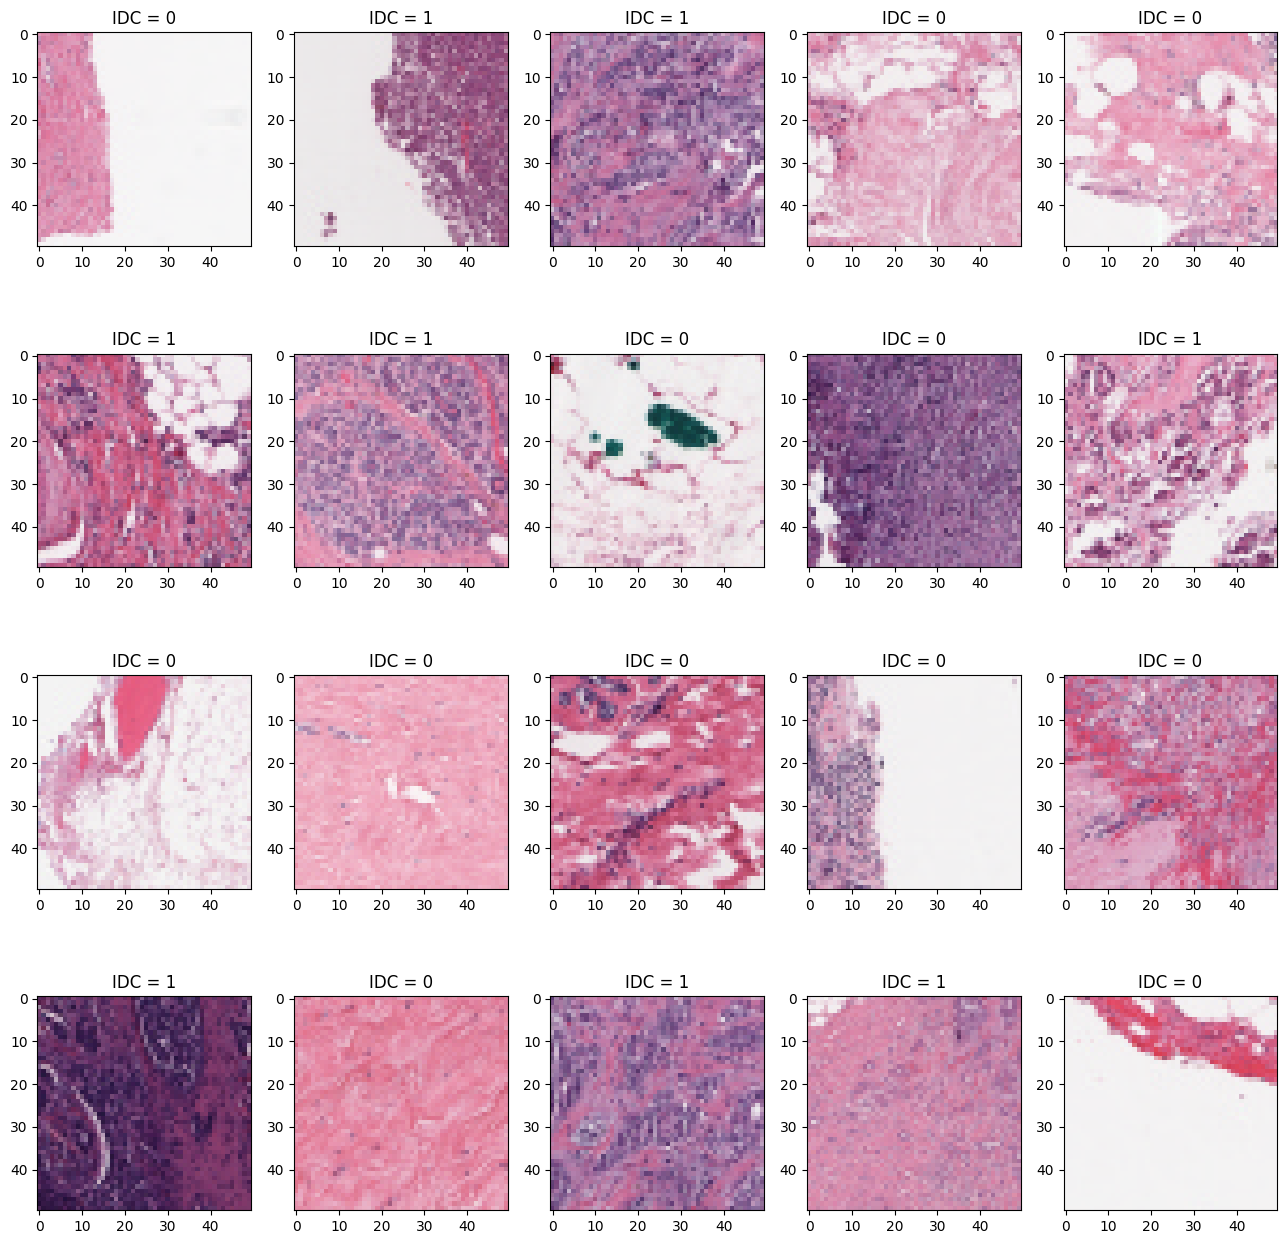

In [62]:
plt.figure(figsize=(16,16))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

### Нормализация данных

In [63]:
X=X/255.0

X_reshaped = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
print(X_reshaped.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y, test_size=0.2)
print('Train size:', X_train.shape,'Test size:', X_test.shape)

(5547, 7500)
Train size: (4437, 7500) Test size: (1110, 7500)


In [64]:
def fit_and_evaluate(model):

    model.fit(X_train, Y_train)

    model_pred = model.predict(X_test)
    model_accuracy = accuracy_score(Y_test, model_pred)

    return model_accuracy

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((4437, 50, 50, 3), (1110, 50, 50, 3), (4437,), (1110,))

In [66]:
ytrain = to_categorical(ytrain,2)
ytest = to_categorical(ytest,2)

In [67]:
import tensorflow as tf

### Создание модели с помощью TensorFlow

In [68]:
tf.keras.backend.clear_session()
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

input_shape = (xtrain.shape[1], xtrain.shape[2], 3)
batch_size = 64
num_classes = 2
epochs = 25
channelDim=-1
INIT_LR=1e-2

model = tf.keras.Sequential()

#first layer
model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(0.2))

#second
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))

#third
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))

#fourth
model.add(SeparableConv2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))

#fifth
model.add(SeparableConv2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))

#sixth
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation("softmax"))


opt=Adagrad(learning_rate=INIT_LR,weight_decay=INIT_LR/epochs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Обучение модели

In [69]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.05,
        fill_mode='nearest'
  )
datagen.fit(xtrain)
history_1=model.fit(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                    epochs=epochs,
                    validation_data = (xtest, ytest),
                    verbose = 2,
                    steps_per_epoch=len(xtrain)/batch_size,
                    shuffle=True)
score_1 = model.evaluate(xtest, ytest, verbose=0)
print(score_1)

Epoch 1/25
69/69 - 6s - loss: 0.9350 - accuracy: 0.6383 - val_loss: 0.7590 - val_accuracy: 0.4973 - 6s/epoch - 86ms/step
Epoch 2/25
69/69 - 5s - loss: 0.6815 - accuracy: 0.6937 - val_loss: 0.9343 - val_accuracy: 0.4973 - 5s/epoch - 71ms/step
Epoch 3/25
69/69 - 5s - loss: 0.6267 - accuracy: 0.7016 - val_loss: 1.0823 - val_accuracy: 0.4973 - 5s/epoch - 75ms/step
Epoch 4/25
69/69 - 5s - loss: 0.5847 - accuracy: 0.7235 - val_loss: 1.2475 - val_accuracy: 0.4973 - 5s/epoch - 75ms/step
Epoch 5/25
69/69 - 12s - loss: 0.5635 - accuracy: 0.7350 - val_loss: 1.9235 - val_accuracy: 0.4973 - 12s/epoch - 178ms/step
Epoch 6/25
69/69 - 13s - loss: 0.5412 - accuracy: 0.7460 - val_loss: 2.9144 - val_accuracy: 0.4973 - 13s/epoch - 185ms/step
Epoch 7/25
69/69 - 13s - loss: 0.5343 - accuracy: 0.7446 - val_loss: 3.1671 - val_accuracy: 0.4973 - 13s/epoch - 184ms/step
Epoch 8/25
69/69 - 13s - loss: 0.5316 - accuracy: 0.7516 - val_loss: 1.3190 - val_accuracy: 0.5279 - 13s/epoch - 185ms/step
Epoch 9/25
69/69 - 1

### Результаты обучения модели

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap='gray_r',
                          linecolor='k'):

    fmt = '.3f' if normalize else 'd'
    sns.heatmap(cm, fmt=fmt, annot=True, square=True,
                xticklabels=classes, yticklabels=classes,
                cmap=cmap, vmin=0, vmax=0,
                linewidths=0.5, linecolor=linecolor,
                cbar=False)
    sns.despine(left=False, right=False, top=False, bottom=False)

    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()


Keras CNN #1A - accuracy: 0.7432432174682617 
35/35 [==============================] - 1s 24ms/step

              precision    recall  f1-score   support

      IDC(-)       0.89      0.56      0.69       558
      IDC(+)       0.68      0.93      0.78       552

    accuracy                           0.74      1110
   macro avg       0.78      0.74      0.73      1110
weighted avg       0.78      0.74      0.73      1110


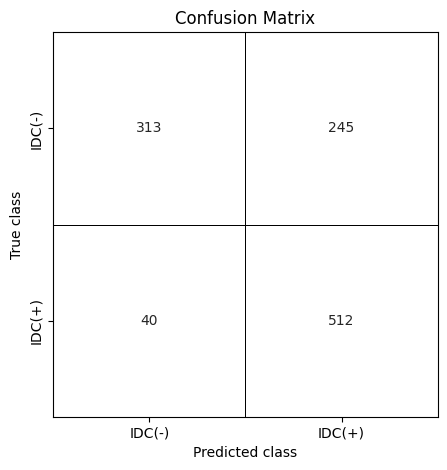

In [71]:
score = model.evaluate(xtest, ytest, verbose=0)
print('\nKeras CNN #1A - accuracy:', score[1],'\n')
y_pred = model.predict(xtest)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1),
                                        target_names=list(map_characters.values())), sep='')
Y_pred_classes = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(ytest,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=["IDC(-)", "IDC(+)"])